In [25]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [27]:
# Load the datasets
train_data = pd.read_excel(r'C:\Users\suhas\OneDrive\Documents\dataset\Train.xlsx')
test_data = pd.read_csv(r'C:\Users\suhas\OneDrive\Documents\dataset\Test.csv')

In [28]:
# Convert 'Date' to datetime in the training data and extract relevant features
train_data['Date'] = pd.to_datetime(train_data['Date'])
train_data['YEAR'] = train_data['Date'].dt.year
train_data['MONTH'] = train_data['Date'].dt.month
train_data['DAY'] = train_data['Date'].dt.day
train_data['HOUR'] = train_data['Date'].dt.hour

# For simplicity, aggregate the crime counts by year and month
monthly_crime_data = train_data.groupby(['YEAR', 'MONTH']).size().reset_index(name='crime_count')

# Select features and target variable for training
X = monthly_crime_data[['YEAR', 'MONTH']]
y = monthly_crime_data['crime_count']

In [29]:
# Split the data using TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)


In [30]:
# Cross-validation and model training
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f'RMSE: {rmse:.4f}')

    


RMSE: 642.2201
RMSE: 281.1946
RMSE: 362.7057


In [31]:
# Training the final model on the entire training set
model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [32]:
# Generate predictions for the test set
# Using YEAR and MONTH from the test dataset
X_test = test_data[['YEAR', 'MONTH']]
predictions = model.predict(X_test)


In [35]:
print("\nPredictions:")
print(submission)


Predictions:
     YEAR  MONTH                                               TYPE  \
0    2013      6  Vehicle Collision or Pedestrian Struck (with I...   
1    2013      6                                   Theft of Vehicle   
2    2013      6                                   Theft of Bicycle   
3    2013      6                                 Theft from Vehicle   
4    2013      6                                        Other Theft   
..    ...    ...                                                ...   
157  2012      1                                        Other Theft   
158  2012      1                           Offence Against a Person   
159  2012      1                                           Mischief   
160  2012      1                  Break and Enter Residential/Other   
161  2012      1                         Break and Enter Commercial   

     Incident_Counts  
0        2851.119629  
1        2851.119629  
2        2851.119629  
3        2851.119629  
4        2851.1196

In [34]:
# Prepare the submission file
submission = pd.DataFrame({
    'YEAR': test_data['YEAR'],
    'MONTH': test_data['MONTH'],  # Include the MONTH column
    'TYPE': test_data['TYPE'],
    'Incident_Counts': predictions
})

# Ensure the predictions are non-negative (crime counts cannot be negative)
submission['Incident_Counts'] = submission['Incident_Counts'].apply(lambda x: max(0, x))

# Save the submission file
submission.to_csv(r'C:\Users\suhas\OneDrive\Documents\dataset\Submission.csv', index=False)

print(r"Submission file saved at: C:\Users\suhas\OneDrive\Documents\dataset\Submission.csv")


Submission file saved at: C:\Users\suhas\OneDrive\Documents\dataset\Submission.csv


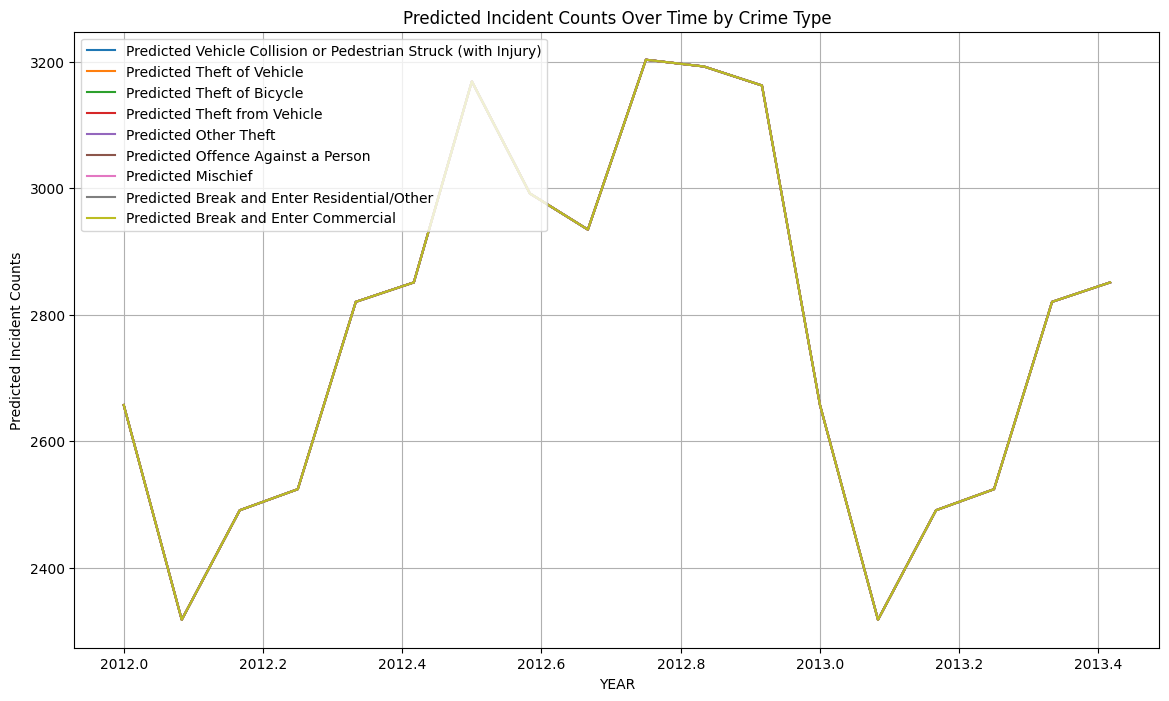

In [36]:
# 1. Plot the predicted incident counts for each crime type over time
plt.figure(figsize=(14, 8))
for crime_type in submission['TYPE'].unique():
    crime_data = submission[submission['TYPE'] == crime_type]
    
    # Combine YEAR and MONTH for better granularity in x-axis
    x_values = crime_data['YEAR'] + (crime_data['MONTH'] - 1) / 12
    y_values = crime_data['Incident_Counts']
    
    plt.plot(x_values, y_values, label=f'Predicted {crime_type}')
    
plt.xlabel('YEAR')
plt.ylabel('Predicted Incident Counts')
plt.title('Predicted Incident Counts Over Time by Crime Type')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


In [37]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


C:\Users\suhas\AppData\Local\Temp\ipykernel_9192\913123268.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  crime_data['date'] = pd.to_datetime(crime_data['YEAR'].astype(str) + '-' + crime_data['MONTH'].astype(str))
C:\Users\suhas\AppData\Local\Temp\ipykernel_9192\913123268.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y = y.fillna(method='ffill')


Error fitting ARIMA model: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=261.370, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=338.715, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=260.020, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=258.359, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=251.346, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=252.048, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=250.139, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : 

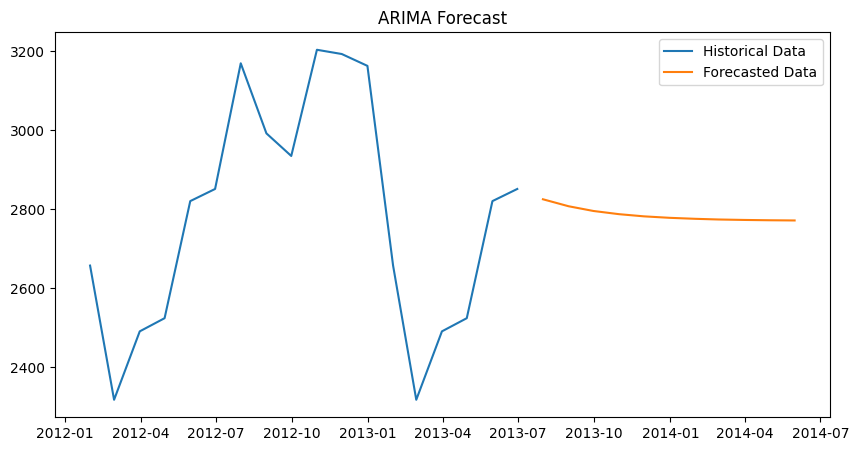

In [38]:
from pmdarima import auto_arima
import pandas as pd
import matplotlib.pyplot as plt

# Prepare data
crime_data = submission.copy()
crime_data['date'] = pd.to_datetime(crime_data['YEAR'].astype(str) + '-' + crime_data['MONTH'].astype(str))
crime_data.set_index('date', inplace=True)

# Filter for a specific crime type (optional)
crime_data = crime_data[crime_data['TYPE'] == 'Mischief']
y = crime_data['Incident_Counts'].resample('M').sum()

# Check and handle missing values
y = y.fillna(method='ffill')

# Automatically determine the best ARIMA parameters
try:
    model = auto_arima(y, seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True)
except ValueError as e:
    print(f"Error fitting ARIMA model: {e}")
    # Handle the error or try a simpler model
    model = auto_arima(y, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y)

# Forecast future data points
forecast = model.predict(n_periods=12)  # Predict 12 months ahead
forecast_index = pd.date_range(y.index[-1], periods=12, freq='M')
forecast_series = pd.Series(forecast, index=forecast_index)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(y, label='Historical Data')
plt.plot(forecast_series, label='Forecasted Data')
plt.title('ARIMA Forecast')
plt.legend()
plt.show()
